In [1]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline # Using alias to avoid overlapping with pipeline from sklearn

pd.options.display.float_format = "{:.2f}".format

In [2]:
df = pd.read_csv("training_data.csv")

In [3]:
df.head(10)

,Unnamed: 0,ID,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,78830894-cdd8-43d1-9655-03db74141b7a,Female,80.00,0,1,never,25.19,6.60,140,0
1,1,32262c0e-903a-46b8-9061-b1a2f5a3e9b2,Female,54.00,0,0,No Info,27.32,6.60,80,0
2,2,c4868b73-ca90-48ed-af14-3d1f78a5f030,Male,28.00,0,0,never,27.32,5.70,158,0
3,3,bec2ef91-5aff-48df-ac16-cb210b5f29fa,Female,36.00,0,0,current,23.45,5.00,155,0
4,4,1a6852a8-ee80-4d93-bea0-f0cdd941dc3d,Male,76.00,1,1,current,20.14,4.80,155,0
5,5,7802d74d-05d1-4c63-b7de-b2f542a47144,Female,20.00,0,0,never,27.32,6.60,85,0
6,6,611e6102-1b62-459f-9953-4a826265b7cd,Female,44.00,0,0,never,19.31,6.50,200,1
7,7,46072bf3-849f-492a-bd66-5bee7aa1b3a1,Female,79.00,0,0,No Info,23.86,5.70,85,0
8,8,a2a429e9-7417-465e-bb46-b59fec795158,Male,42.00,0,0,never,33.64,4.80,145,0
9,9,a643e921-ce86-4cff-8d70-92ea454b7266,Female,32.00,0,0,never,27.32,5.00,100,0


### Dropping possible duplicates

In [4]:
df = df.drop_duplicates()

### Uniqueness

In [5]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct_values")

Unnamed: 0: 73718 distinct_values
ID: 70000 distinct_values
gender: 3 distinct_values
age: 102 distinct_values
hypertension: 2 distinct_values
heart_disease: 2 distinct_values
smoking_history: 6 distinct_values
bmi: 4069 distinct_values
HbA1c_level: 18 distinct_values
blood_glucose_level: 18 distinct_values
diabetes: 2 distinct_values


### Missing values

In [6]:
print(df.isnull().sum(0))

Unnamed: 0             0
ID                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


### Removing unnecessary data

In [7]:
df = df[df["gender"] != "Other"]

### Describe dataset

In [8]:
df.describe().style.format("{:.2f}")

,Unnamed: 0,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,73706.00,73706.00,73706.00,73706.00,73706.00,73706.00,73706.00,73706.00
mean,36859.45,41.86,0.08,0.04,27.35,5.53,138.20,0.09
std,21281.25,22.49,0.27,0.20,6.78,1.07,40.89,0.28
min,0.00,0.08,0.00,0.00,10.01,3.50,80.00,0.00
25%,18430.25,24.00,0.00,0.00,23.43,4.80,100.00,0.00
50%,36859.50,43.00,0.00,0.00,27.32,5.80,140.00,0.00
75%,55290.75,59.00,0.00,0.00,29.90,6.20,159.00,0.00
max,73717.00,80.00,1.00,1.00,95.69,9.00,300.00,1.00


### Plots to observe the distribution

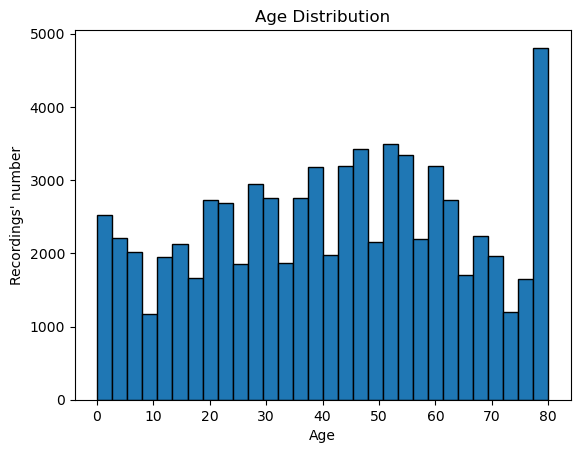

In [9]:
plt.hist(df["age"], bins = 30, edgecolor = "black")
plt.xlabel("Age")
plt.ylabel("Recordings' number")
plt.title("Age Distribution")
plt.show()

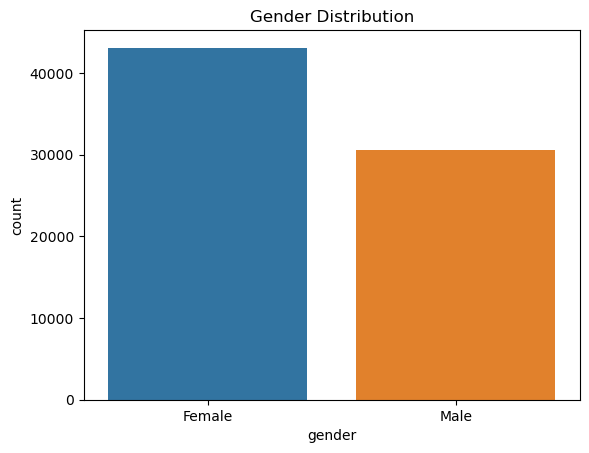

In [10]:
sns.countplot(x = "gender", data = df)
plt.title("Gender Distribution")
plt.show()

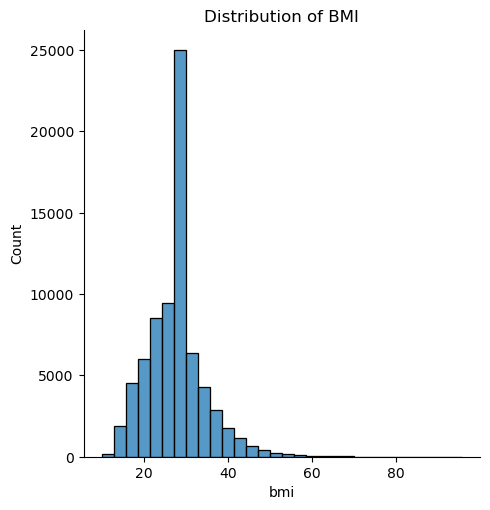

In [11]:
sns.displot(df["bmi"], bins = 30)
plt.title("Distribution of BMI")
plt.show()

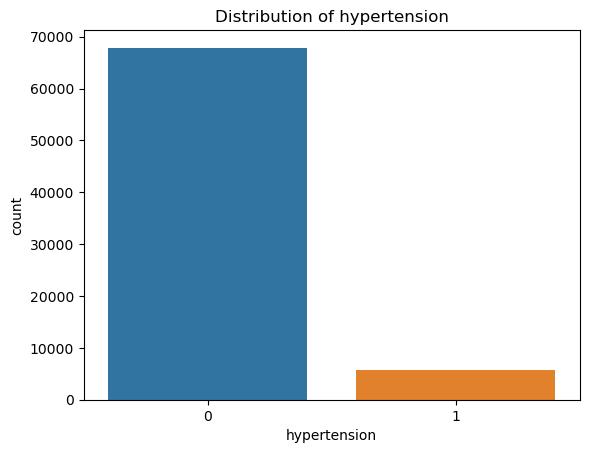

In [12]:
sns.countplot(x = "hypertension", data = df)
plt.title("Distribution of hypertension")
plt.show()

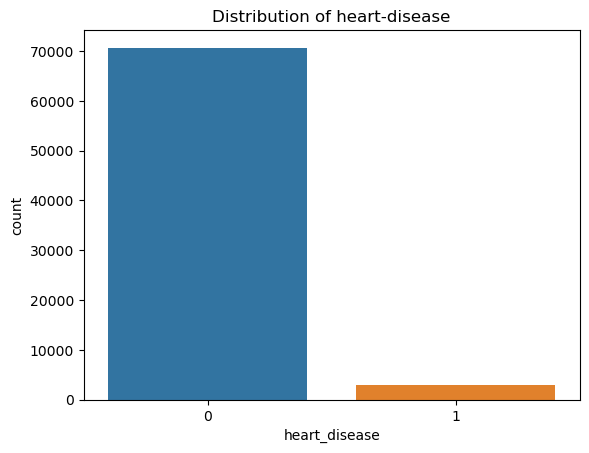

In [13]:
sns.countplot(x = "heart_disease", data = df)
plt.title("Distribution of heart-disease")
plt.show()

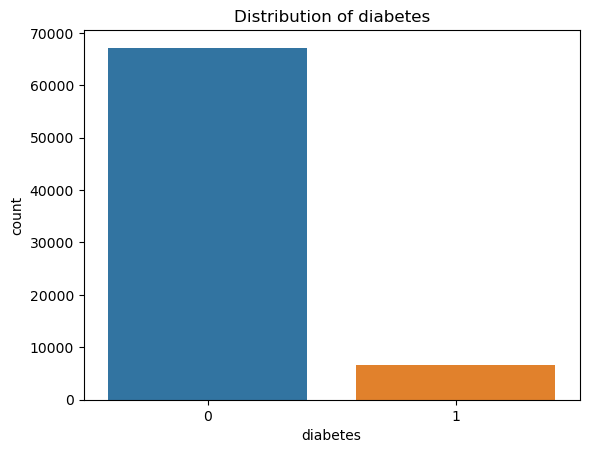

In [14]:
sns.countplot(x = "diabetes", data = df)
plt.title("Distribution of diabetes")
plt.show()

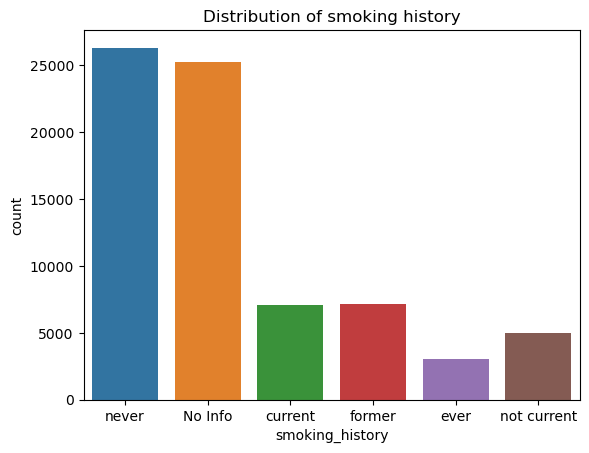

In [15]:
sns.countplot(x = "smoking_history", data = df)
plt.title("Distribution of smoking history")
plt.show()

## Bivariative Analysis

### Boxplot BMI vs Diabetes classification

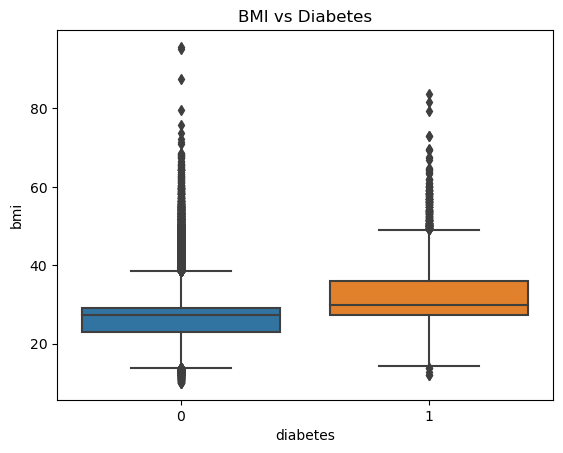

In [16]:
sns.boxplot(x = "diabetes", y = "bmi", data = df)
plt.title("BMI vs Diabetes")
plt.show()

## Boxplot age vs diabetes classification

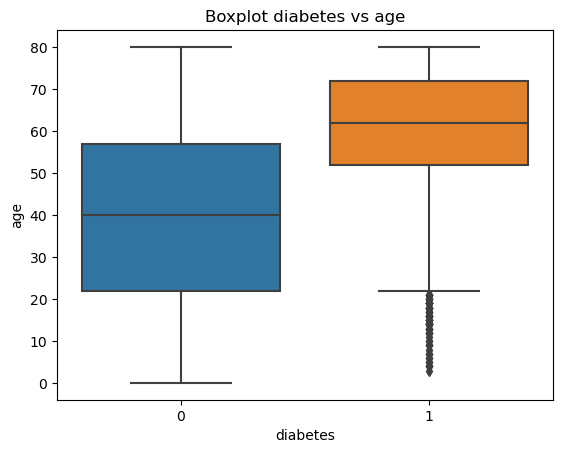

In [17]:
sns.boxplot(x = "diabetes", y = "age", data = df)
plt.title("Boxplot diabetes vs age")
plt.show()

## Boxplot HbA1c_level	vs diabetes classification

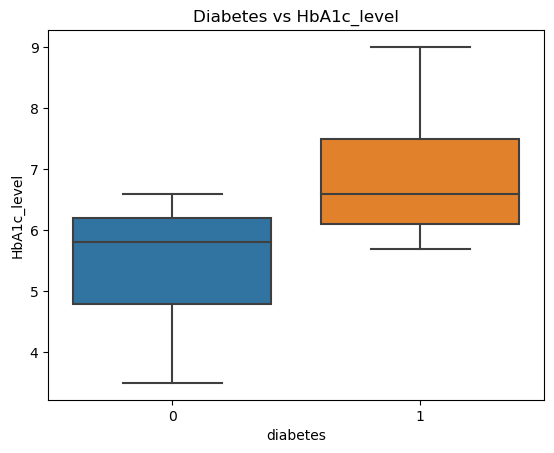

In [18]:
sns.boxplot(x = "diabetes", y = "HbA1c_level", data = df)
plt.title("Diabetes vs HbA1c_level")
plt.show()

## Boxplot blood_glucose_level vs diabetes classification

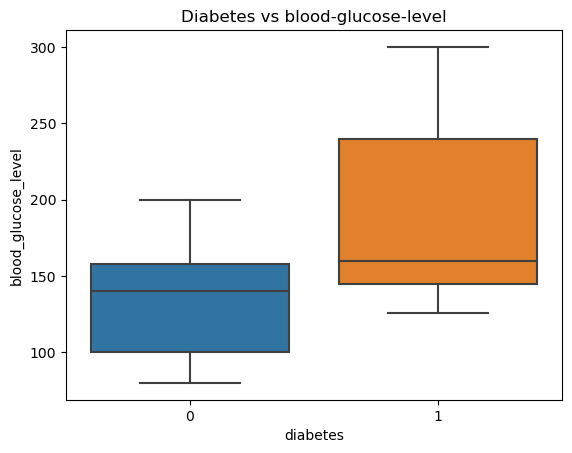

In [19]:
sns.boxplot(x = "diabetes", y = "blood_glucose_level", data = df)
plt.title("Diabetes vs blood-glucose-level")
plt.show()

## Multivariative analysis

### Scatterplotting Age vs BMI colored by Diabetes classification

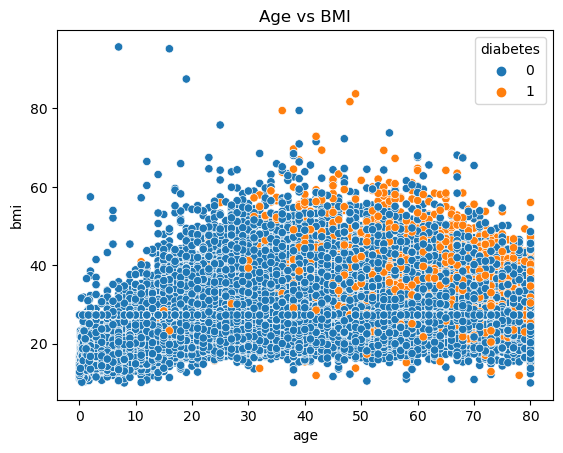

In [20]:
sns.scatterplot(x = "age", y = "bmi", data = df, hue = "diabetes")
plt.title("Age vs BMI")
plt.show()

## Violin plot of BMI against diabetes classification split by gender

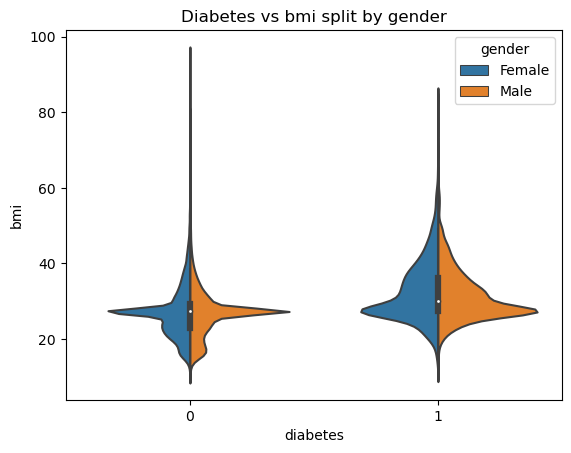

In [21]:
sns.violinplot(x = "diabetes", y = "bmi", hue = "gender", split = True, data = df)
plt.title("Diabetes vs bmi split by gender")
plt.show()

### Interaction between gender, bmi and diabetes

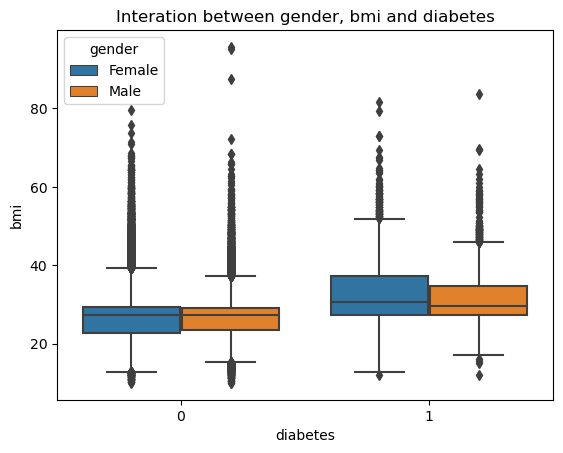

In [22]:
sns.boxplot(x = "diabetes", y = "bmi", hue = "gender", data = df)
plt.title("Interation between gender, bmi and diabetes")
plt.show()

## Interaction between gender, age and daibetes

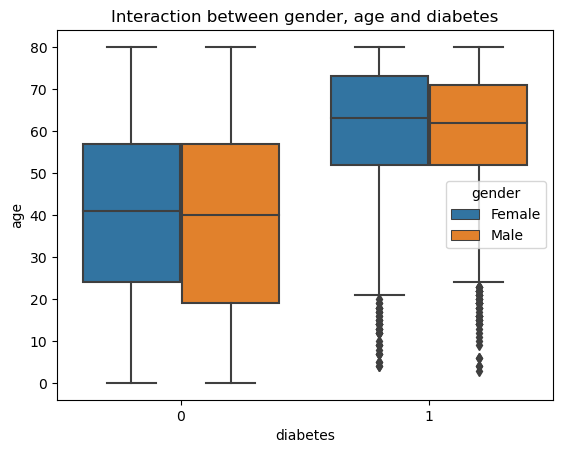

In [23]:
sns.boxplot(x = "diabetes", y = "age", hue = "gender", data = df)
plt.title("Interaction between gender, age and diabetes")
plt.show()

In [24]:
def group_smoking(status):
    if status in ["never", "No Info"]:
        return "not_smoker"
    elif status in ["current"]:
        return "smoker"
    elif status in ["former", "ever", "not current"]:
        return "ex_smoker"

df["smoking_history"] = df["smoking_history"].apply(group_smoking)

In [25]:
print(df["smoking_history"].value_counts())

smoking_history
not_smoker    51526
ex_smoker     15145
smoker         7035
Name: count, dtype: int64


In [26]:
data = df.copy()

In [27]:
def perform_one_hot_encoding(df, column_name):
    # Perform one-hot encoding on the specified column
    dummies = pd.get_dummies(df[column_name], prefix=column_name)

    # Drop the original column and append the new dummy columns to the dataframe
    df = pd.concat([df.drop(column_name, axis=1), dummies], axis=1)

    return df

# Perform one-hot encoding on the gender variable
data = perform_one_hot_encoding(data, 'gender')

# Perform one-hot encoding on the smoking history variable
data = perform_one_hot_encoding(data, 'smoking_history')

In [29]:
data = data.drop("ID", axis = 1)


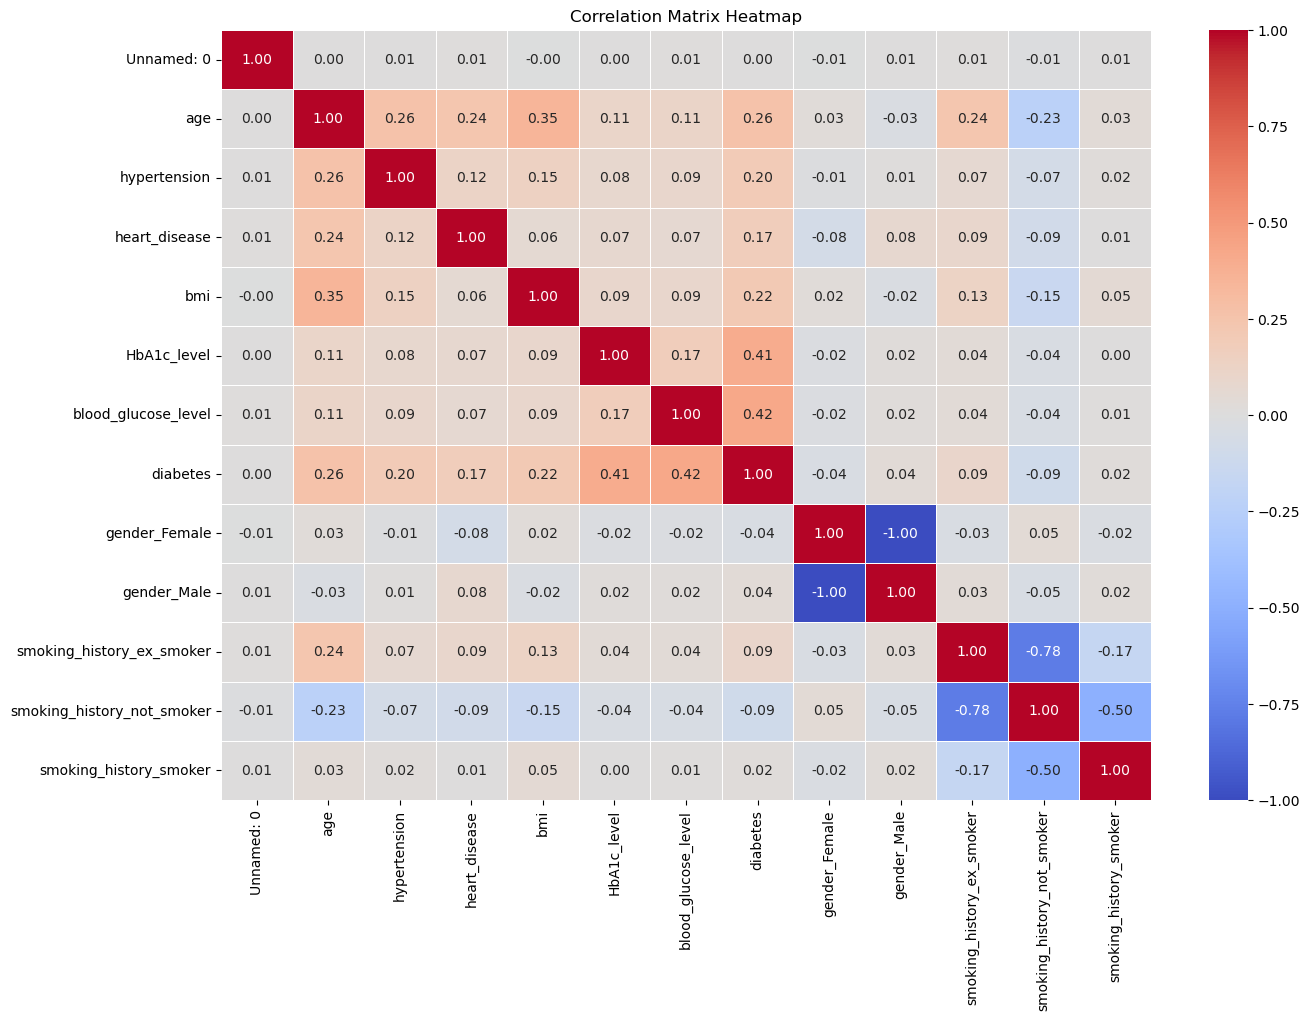

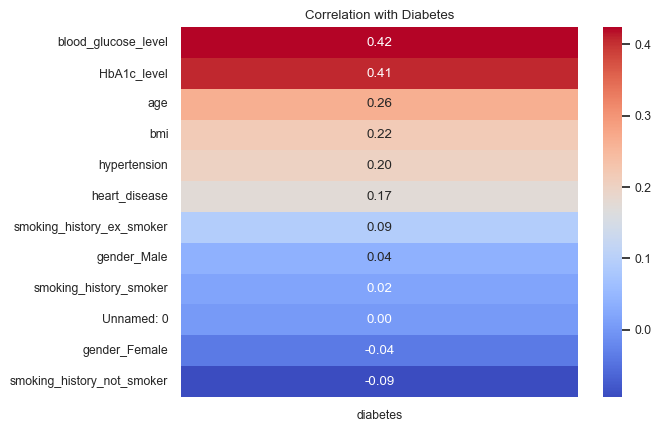

In [30]:
correlation_matrix = data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()


#Graph II
# Create a heatmap of the correlations with the target column
corr = data.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

## Class imbalance

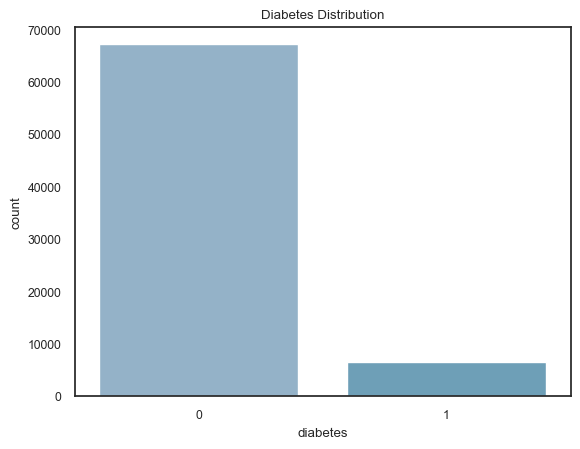

In [31]:
sns.countplot(x= "diabetes", data = df)
plt.title("Diabetes Distribution")
plt.show()

In [32]:
over = SMOTE(sampling_strategy = 0.1)
under = RandomUnderSampler(sampling_strategy = 0.5)

## Preprocessing: Scaler

In [33]:
preprocessor = ColumnTransformer(
    transformers = [
        ("num", StandardScaler(), ["age", "bmi", "HbA1c_level", "blood_glucose_level", "hypertension", "heart_disease"]),
        ("cat", OneHotEncoder(), ["gender", "smoking_history"])
    ])

X = df.drop("diabetes", axis = 1)
y = df["diabetes"]


In [34]:
clf = imbPipeline(steps=[('preprocessor', preprocessor),
                      ('over', over),
                      ('under', under),
                      ('classifier', RandomForestClassifier())])

## Model building and hyperparametr tuning

In [35]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [36]:
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}


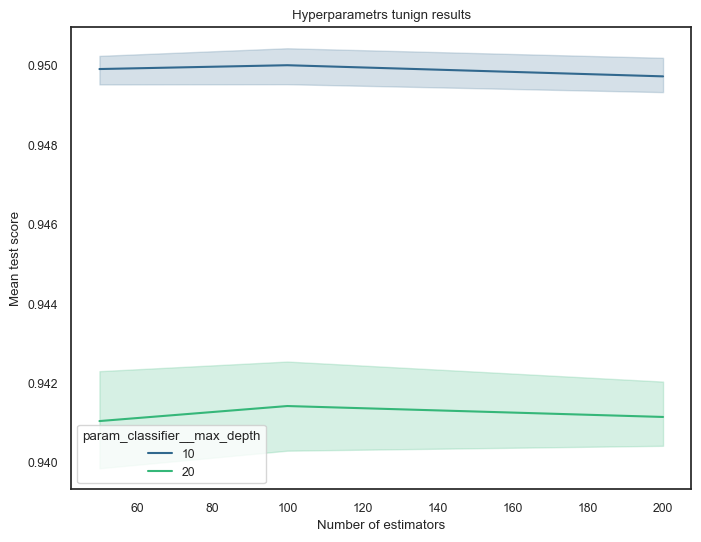

In [43]:
results_df = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize = (8, 6))
sns.lineplot(data = results_df, x = "param_classifier__n_estimators", y = "mean_test_score", hue = "param_classifier__max_depth", palette = "viridis")
plt.title("Hyperparametrs tunign results")
plt.xlabel("Number of estimators")
plt.ylabel("Mean test score")
plt.show()

Model Accuracy:  0.9528557861891195
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     13425
           1       0.70      0.82      0.76      1317

    accuracy                           0.95     14742
   macro avg       0.84      0.89      0.87     14742
weighted avg       0.96      0.95      0.95     14742



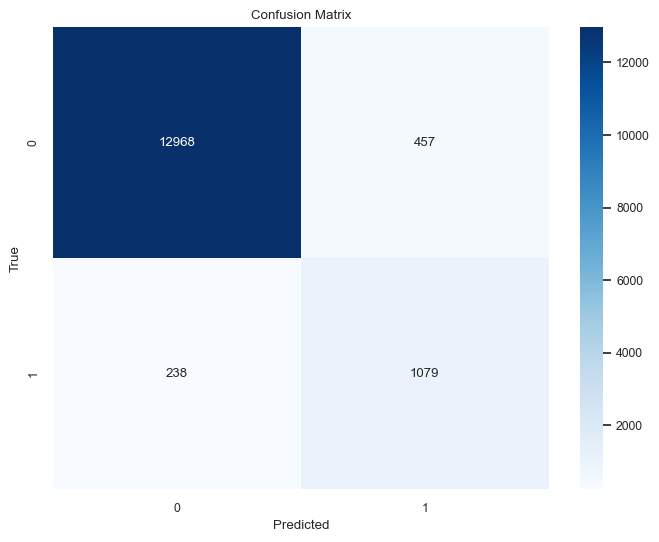

In [52]:
y_pred = grid_search.predict(X_test)
print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [55]:
test_data = pd.read_csv("test_data.csv")
test_data["smoking_history"] = test_data["smoking_history"].apply(group_smoking)
test_data = test_data[test_data["gender"] != "Other"]

In [56]:
final_pred = grid_search.predict(test_data)

In [57]:
final_pred

array([0, 0, 1, ..., 1, 0, 0])

In [63]:
test_data = test_data.drop("diabetes", axis = 1)
test_data["prediction"] = final_pred
test_data

,Unnamed: 0,ID,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,prediction
0,0,ba0d6256-ca6e-46a7-a2fb-2518a8937fd7,Female,60.00,1,0,ex_smoker,23.77,4.80,130,0
1,1,7102b1ab-c7a4-4a43-b1fc-cb588d0553b8,Male,2.00,0,0,not_smoker,15.19,5.00,159,0
2,2,51ba207e-4934-41b4-a31c-cd275c5ca555,Female,74.00,0,0,ex_smoker,39.59,6.50,160,1
3,3,7e17faaa-0402-4728-9719-83982eba3afd,Female,51.00,0,0,not_smoker,26.67,6.60,80,0
4,4,08b4e515-286e-4393-9a55-138962f9546e,Male,35.00,0,0,not_smoker,26.09,3.50,159,0
...,...,...,...,...,...,...,...,...,...,...,...
26141,26141,1f8db6fe-03f8-48ca-9a42-9f12062b002d,Female,31.00,0,0,not_smoker,27.32,6.10,140,0
26142,26142,5bf3ca1a-ced5-474b-a354-cc3bec9f16d3,Female,65.00,1,1,not_smoker,27.25,5.70,100,0
26143,26143,930e6345-a920-47dd-abd0-6bc0be2ae56f,Male,30.00,1,0,ex_smoker,57.17,5.80,300,1
26144,26144,035f3cc4-e8af-448a-8172-a1b027e06de1,Male,20.00,0,0,not_smoker,32.70,6.20,159,0


In [64]:
final = test_data[["ID", "prediction"]]

In [66]:
final.to_csv('Project_3_Dastan_Issenov.csv')